In [1]:
import os
os.chdir('..')

from typing import Optional, List

from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl

from torchmetrics.functional import  accuracy, precision,recall, specificity

from src.models.basemodels.resnet import resnet34

In [48]:
import torch
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.nn import functional as F

In [3]:

class ClassificationModel(pl.LightningModule):
    def __init__(self,
                model: nn.Module,
                criterion: nn.Module,
                optimizer: str = 'sgd',
                learning_rate: float =  1e-2,
                weight_decay: float = 0.0,
                scheduler: Optional[str] = 'step',
                sched_step_size: int = 5,
                sched_gamma: float = 0.5,
                output_dim: int = 2,
                freeze: bool = False,
                max_epochs: int = 50
                ) -> None:
        super(ClassificationModel, self).__init__()

        self.save_hyperparameters()
        self.model = model()
        self.criterion = criterion()
        self.optimizer = optimizer.lower()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler = scheduler
        self.sched_step_size = sched_step_size
        self.sched_gamma = sched_gamma
        self.max_epochs = max_epochs
        self.output_dim = output_dim

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
        
        self.model.fc = nn.Linear(self.model.fc.in_features,self.output_dim)

    def forward(self,
                x: Tensor
               ) -> Tensor:
        return self.model(x)

    def training_step(self, 
                      batch: List[Tensor], 
                      batch_idx: int
                     ) -> float:
        input, label = batch
        prediction = self.model(input)
        loss = self.criterion(prediction, label)
        acc = accuracy(preds=prediction, target=label)
        
        self.log("train_loss", loss, on_epoch= True,on_step=True , logger=True,prog_bar=True)
        self.log("train_acc", acc, on_epoch= True,on_step=True , logger=True,prog_bar=True)
        return loss

    
    def validation_step (self, 
                      batch: List[Tensor], 
                      batch_idx: int
                     ) -> float:
        input,label = batch
        prediction = self.model(input)
        loss = self.criterion(prediction, label)
        acc = accuracy(preds=prediction, target=label)

        self.log("val_loss", loss, on_epoch= True,on_step=True , logger=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch= True,on_step=True , logger=True, prog_bar=True)
        return loss


    def test_step(self, 
                  batch: List[Tensor], 
                  batch_idx: int
                 ) -> float:
        input, label = batch
        prediction = self.model(input)
        loss = self.criterion(prediction, label)
        acc = accuracy(preds=prediction, target=label)

        self.log("test_loss", loss, on_epoch= True,on_step=True , logger=True,prog_bar=True)
        self.log("test_acc", acc, on_epoch= True,on_step=True , logger=True, prog_bar=True)
        return loss 

    def on_fit_start(self) -> None:
        self.logger.experiment.log_artifact(self.logger.run_id,'./args.json')


    def configure_optimizers(self):
        if self.optimizer == 'adam':
            optimizer = optim.Adam(params=self.parameters(), 
                                   lr=self.learning_rate, 
                                   weight_decay=self.weight_decay
                                   )
        elif self.optimizer == 'sgd':
            optimizer = optim.SGD(params=self.parameters(), 
                                   lr=self.learning_rate, 
                                   weight_decay=self.weight_decay
                                   )
        else:
            raise NameError('optimizer must be eithr sgd or adam')


        if self.scheduler == 'step':
            scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                  step_size=self.sched_step_size,
                                                  gamma=self.sched_gamma, verbose=True
                                                 )
        elif self.scheduler == 'exponential':
             scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, 
                                                          gamma=self.sched_gamma, verbose=True
                                                         )
        elif self.scheduler == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                            eta_min=0,
                                                            T_max=self.max_epochs
                                                            )


        elif self.scheduler is None:
            scheduler = None

        else: 
            raise NameError('scheduler must be eithr step or exponential')
        
        return {'optimizer': optimizer,
                'lr_scheduler': scheduler
               }

In [94]:
model = ClassificationModel(model=resnet34,
                            criterion=nn.CrossEntropyLoss,
                            optimizer='adam',
                            learning_rate=0.001,
                            weight_decay=0.0001,
                            scheduler='cosine',
                            output_dim=5,
                            freeze= True,
                            max_epochs=100
                            )

In [95]:
image = '/src/data/down-stream/grading/MRO/test/mild/42.jpg'

In [96]:
image = Image.open(image)

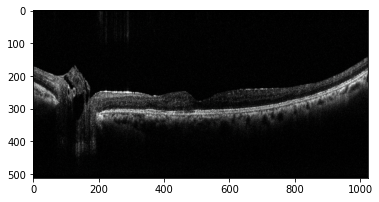

In [97]:
plt.imshow(image, cmap='gray')

In [98]:
transforms = T.Compose([T.Resize((224,224)),
                        T.ToTensor()])

In [99]:
image = transforms(image)

In [100]:
image = image.unsqueeze(0)

In [101]:
model.model(image)

tensor([[-0.2113,  1.1687,  0.0508,  0.4395, -0.6529]],
       grad_fn=<AddmmBackward0>)

In [108]:
train_dataset = ImageFolder(root='/src/data/down-stream/grading/MRO/train',transform = transforms)
train_dataloader = DataLoader(dataset= train_dataset, batch_size= 1, shuffle= True)

In [109]:
train_dataset.class_to_idx

{'mild': 0, 'moderate': 1, 'severe': 2}

In [110]:
image,label = next(iter(train_dataloader))

In [111]:
label

tensor([1])

In [129]:
pred = model.model(image)
pred

tensor([[-0.1126,  1.0281,  0.0953,  0.4297, -0.6208]],
       grad_fn=<AddmmBackward0>)

In [113]:
F.cross_entropy(pred,label)

tensor(0.8981, grad_fn=<NllLossBackward0>)

In [118]:
input = torch.randn(3, 5, requires_grad=True)


In [126]:
input

tensor([[-0.2957, -1.0522, -0.4160, -1.7559,  0.4575],
        [-0.7434, -0.9817, -1.3046,  0.6905, -0.4855],
        [ 1.2950, -0.1555,  0.5719,  0.2225, -0.7019]], requires_grad=True)

In [127]:
target = torch.randint(5, (3,), dtype=torch.int64)

In [128]:
target

tensor([2, 3, 0])

In [124]:
loss = F.cross_entropy(input, target)

In [125]:
loss

tensor(2.2731, grad_fn=<NllLossBackward0>)